# GridSearchCV for Models (Logistic Regression (LR) and Random Forest Classifier (RF) with Recursive Feature Elimination with Cross-validation (RFECV) - Breast cancer Wisconsin Dataset



# Descripcion

Se trata de un conjunto de datos en el que las características se calculan a partir de una imagen digitalizada de un aspirado con aguja fina (FNA) de una masa mamaria. Describen las características de los núcleos celulares presentes en la imagen. Enlace: https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data

Información de atributos:

1) Número de identificación
2) Diagnóstico (M = maligno, B = benigno)
3-32)

Se calculan diez features de valor real para cada núcleo celular:

- a) radio (media de las distancias del centro a los puntos del perímetro)
- b) textura (desviación estándar de los valores en escala de grises)
- c) perímetro
- d) área
- e) suavidad (variación local de las longitudes de los radios)
- f) compacidad (perímetro^2 / área - 1,0)
- g) concavidad (gravedad de las partes cóncavas del contorno)
- h) puntos cóncavos (número de porciones cóncavas del contorno)
- i) simetría
- j) dimensión fractal ("aproximación a la línea de costa" - 1)

Para cada imagen se calcularon la media, el error estándar y el "peor" o mayor (media de los tres valores más grandes) de estas características, lo que dio como resultado 30 características. Por ejemplo, el campo 3 es el radio medio, el campo 13 es el radio SE, el campo 23 es el peor radio

## Objetivo y Tecnica

Precedir cancer de mamas a traves de analizar diferentes features de fine needle aspiration (FNA) de una masa mamaria. The target es "diagnosis" el cual sera B (Benigno) o M (Maligno)

Crear un modelo de Logistic Regression (LR) and Random Forest Classifier (RF) utilizando Recursive Feature Elimination with Cross-validation (RFECV) en ambos modelos para encontrar el numero de features necesarias. Ademas usar GridSearch para encontrar mejores parametros.



# 1. Importar librerias y cargar Dataset

In [4]:
# importamos las librerías necesarias para trabajar.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


In [5]:
data = pd.read_csv("breast_cancer_wisconsin.csv")

# 2. Data Description

In [6]:
#First view
data.head()

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_worst  smoothness_worst  \
0  ...          17.33           184.60      2019.0            0.1622   
1  ...          23.41           158.80      1956.0            0.1238   
2  ...          25.53           152.50      1709.0            0.1444   
3  ...          26.50            98.87       567.7            0.2098   
4  ...          16.67           152.20      1575.0            0.1374   

   compactness_worst  concavity_worst  concave points_worst  symmetry_worst  \
0             0.6656           0.7119                0.2654          0.4601   
1             0.1866           0.2416                0.1860          0.2750   
2             0.4245           0.4504                0.2430          0.3613   
3             0.8663           0.6869                0.2575          0.6638   
4             0.2050           0.4000                0.1625          0.2364   

   fractal_dimension_worst  Unnamed: 32  
0                  0.11890          NaN  
1                  0.08902          NaN  
2                  0.08758          NaN  
3                  0.17300          NaN  
4                  0.07678          NaN  

[5 rows x 33 columns]

In [7]:
print(data.shape)
print()
data.info()

(569, 33)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se   

Observamos 569 samples y 33 features

Son 33 features --> 31 float, 1 int64 ("id") y 1 object ("diagnosis").
Tambien se observa columna 32 sin non-null. 
La columna "id" se puede utilizar como indice ya que no nos aporta nada para el modelo de prediccion

In [8]:
print(data["Unnamed: 32"].isna().all())
# Compruebo que todas sus filas son Nans asi que elimino
data.drop(columns="Unnamed: 32", inplace=True)

True


In [9]:
# Ademas aprovecho que tengo los Id y los convierto en indices
data.set_index("id", inplace=True)

In [10]:
#COnfirmo que tengo de indice a "id" y que elimine la ultima columna
print(data.index.name)
data.shape

id


(569, 31)

# 3. Exploratory Data Analysis


## 1. Missing Values

In [11]:
data.isna().sum()/data.shape[0]*100 
data.isnull().any().value_counts() 

#En este caso no presenta Nans

False    31
dtype: int64

## 2. Busqueda de duplicados

In [12]:
data.duplicated().any() # No presenta duplicados

False

# 4. Exploratory Data Analysis

## 4.1 Univariate Analysis  

Primero voy a separar el traget("diagnosis") de mis features

Como presenta varias features, para su mejor visualizacion y analisis las voy a dividir en sus 3 subrupos segun si son "mean", "se"(Standar Error) y "worst"

In [13]:
#Separo target (y) de features (x)

data_x = data.iloc[:,1:]
data_y = data.iloc[:,0]

data_y.name



'diagnosis'

In [14]:
Y = pd.get_dummies(data_y, drop_first=True)
Y

M
id         
842302    1
842517    1
84300903  1
84348301  1
84358402  1
...      ..
926424    1
926682    1
926954    1
927241    1
92751     0

[569 rows x 1 columns]

In [15]:
# Separo en los subgrupos

mean_features = data.loc[:, data.columns.str.contains('_mean')]
se_features = data.loc[:, data.columns.str.contains('_se')]
worst_features = data.loc[:, data.columns.str.contains('_worst')]

### Rapida distribucion entre las variables


In [16]:
mean_features.describe()

radius_mean  texture_mean  perimeter_mean    area_mean  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%           0.086370          0.064920        0.029560             0.020310   
50%           0.095870          0.092630        0.061540             0.033500   
75%           0.105300          0.130400        0.130700             0.074000   
max           0.163400          0.345400        0.426800             0.201200   

       symmetry_mean  fractal_dimension_mean  
count     569.000000              569.000000  
mean        0.181162                0.062798  
std         0.027414                0.007060  
min         0.106000                0.049960  
25%         0.161900                0.057700  
50%         0.179200                0.061540  
75%         0.195700                0.066120  
max         0.304000                0.097440

In [17]:
se_features.describe()


radius_se  texture_se  perimeter_se     area_se  smoothness_se  \
count  569.000000  569.000000    569.000000  569.000000     569.000000   
mean     0.405172    1.216853      2.866059   40.337079       0.007041   
std      0.277313    0.551648      2.021855   45.491006       0.003003   
min      0.111500    0.360200      0.757000    6.802000       0.001713   
25%      0.232400    0.833900      1.606000   17.850000       0.005169   
50%      0.324200    1.108000      2.287000   24.530000       0.006380   
75%      0.478900    1.474000      3.357000   45.190000       0.008146   
max      2.873000    4.885000     21.980000  542.200000       0.031130   

       compactness_se  concavity_se  concave points_se  symmetry_se  \
count      569.000000    569.000000         569.000000   569.000000   
mean         0.025478      0.031894           0.011796     0.020542   
std          0.017908      0.030186           0.006170     0.008266   
min          0.002252      0.000000           0.000000     0.007882   
25%          0.013080      0.015090           0.007638     0.015160   
50%          0.020450      0.025890           0.010930     0.018730   
75%          0.032450      0.042050           0.014710     0.023480   
max          0.135400      0.396000           0.052790     0.078950   

       fractal_dimension_se  
count            569.000000  
mean               0.003795  
std                0.002646  
min                0.000895  
25%                0.002248  
50%                0.003187  
75%                0.004558  
max                0.029840

In [18]:
worst_features.describe()

radius_worst  texture_worst  perimeter_worst   area_worst  \
count    569.000000     569.000000       569.000000   569.000000   
mean      16.269190      25.677223       107.261213   880.583128   
std        4.833242       6.146258        33.602542   569.356993   
min        7.930000      12.020000        50.410000   185.200000   
25%       13.010000      21.080000        84.110000   515.300000   
50%       14.970000      25.410000        97.660000   686.500000   
75%       18.790000      29.720000       125.400000  1084.000000   
max       36.040000      49.540000       251.200000  4254.000000   

       smoothness_worst  compactness_worst  concavity_worst  \
count        569.000000         569.000000       569.000000   
mean           0.132369           0.254265         0.272188   
std            0.022832           0.157336         0.208624   
min            0.071170           0.027290         0.000000   
25%            0.116600           0.147200         0.114500   
50%            0.131300           0.211900         0.226700   
75%            0.146000           0.339100         0.382900   
max            0.222600           1.058000         1.252000   

       concave points_worst  symmetry_worst  fractal_dimension_worst  
count            569.000000      569.000000               569.000000  
mean               0.114606        0.290076                 0.083946  
std                0.065732        0.061867                 0.018061  
min                0.000000        0.156500                 0.055040  
25%                0.064930        0.250400                 0.071460  
50%                0.099930        0.282200                 0.080040  
75%                0.161400        0.317900                 0.092080  
max                0.291000        0.663800                 0.207500

Observo que la feauture "mean" presenta un max muy alejado de su mediana por lo cual debe tener una distribucion sesgada a la derecha. Ademas las magnitudes son muy dispares, por lo cual para mejor visualizacion y para el modelo voy a tener que estandarizarlas


### Distribucion con histograma y KDE

In [19]:
# Creo funcion para histogramas

def histograms_plot(dataframe, features, rows, cols):   
    fig = plt.figure( figsize=(cols*3, rows*3))
    for i, col in enumerate(features):    
        ax=fig.add_subplot(rows,cols,i+1)    
        sns.histplot( x=dataframe[col], kde=True, color="teal", ax=ax)      
    
    fig.tight_layout()  
    plt.show()


### Mean

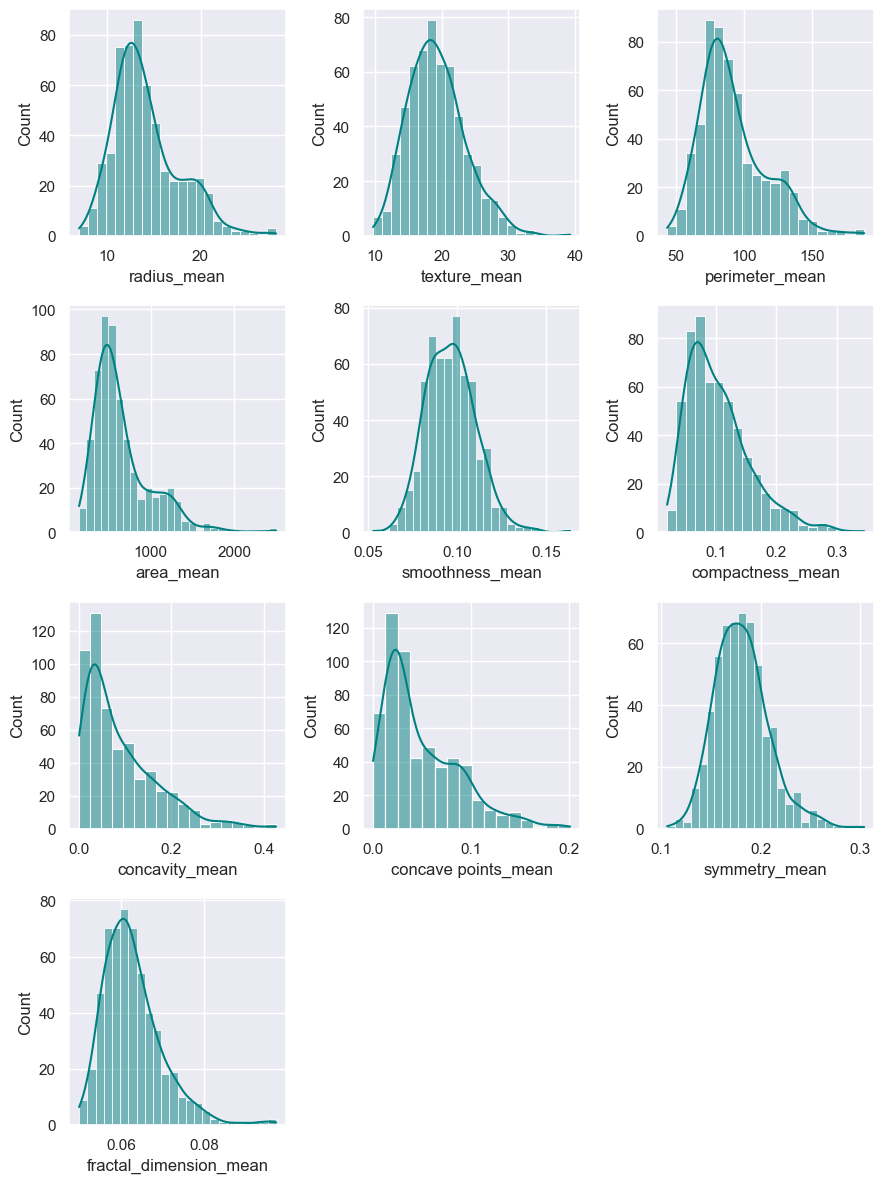

In [20]:
histograms_plot(mean_features, mean_features, 4,3)

### Standard Error

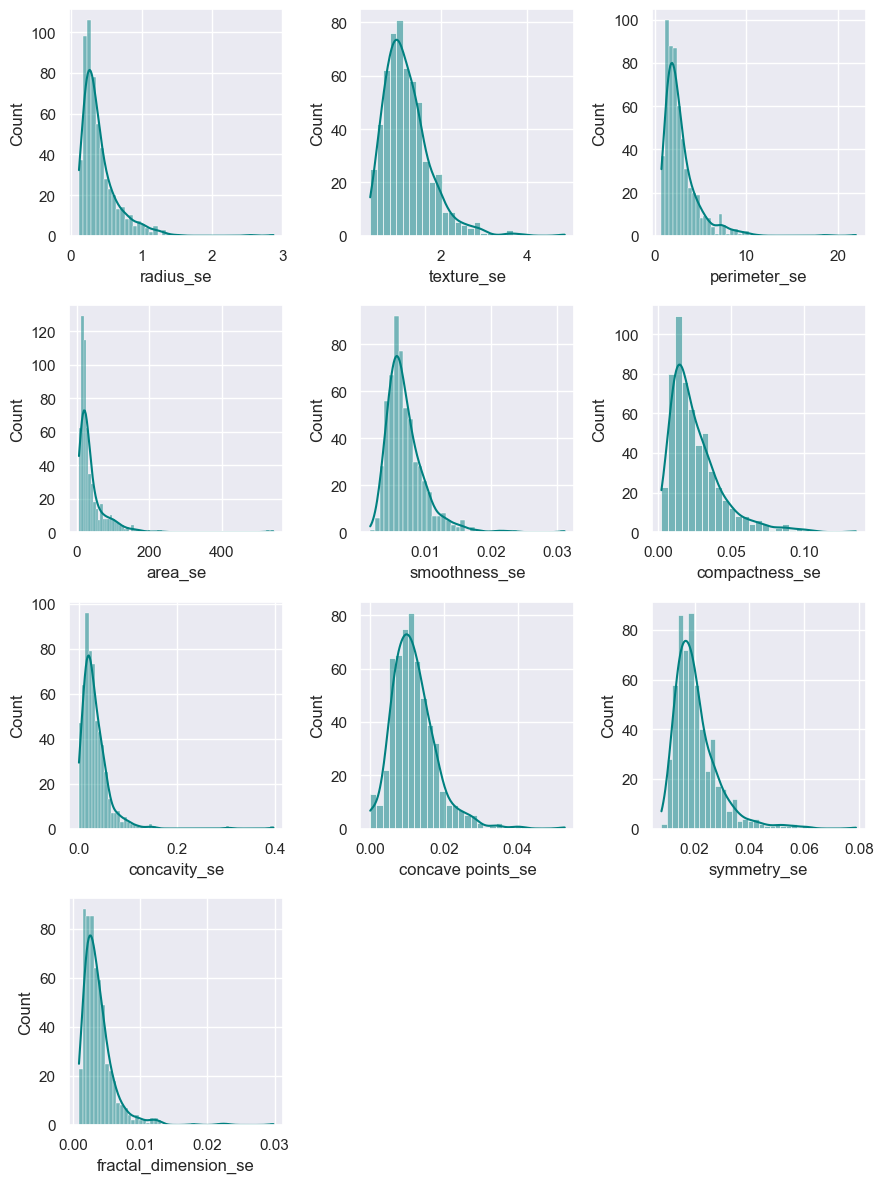

In [21]:
histograms_plot(se_features, se_features, 4,3)

### Worst

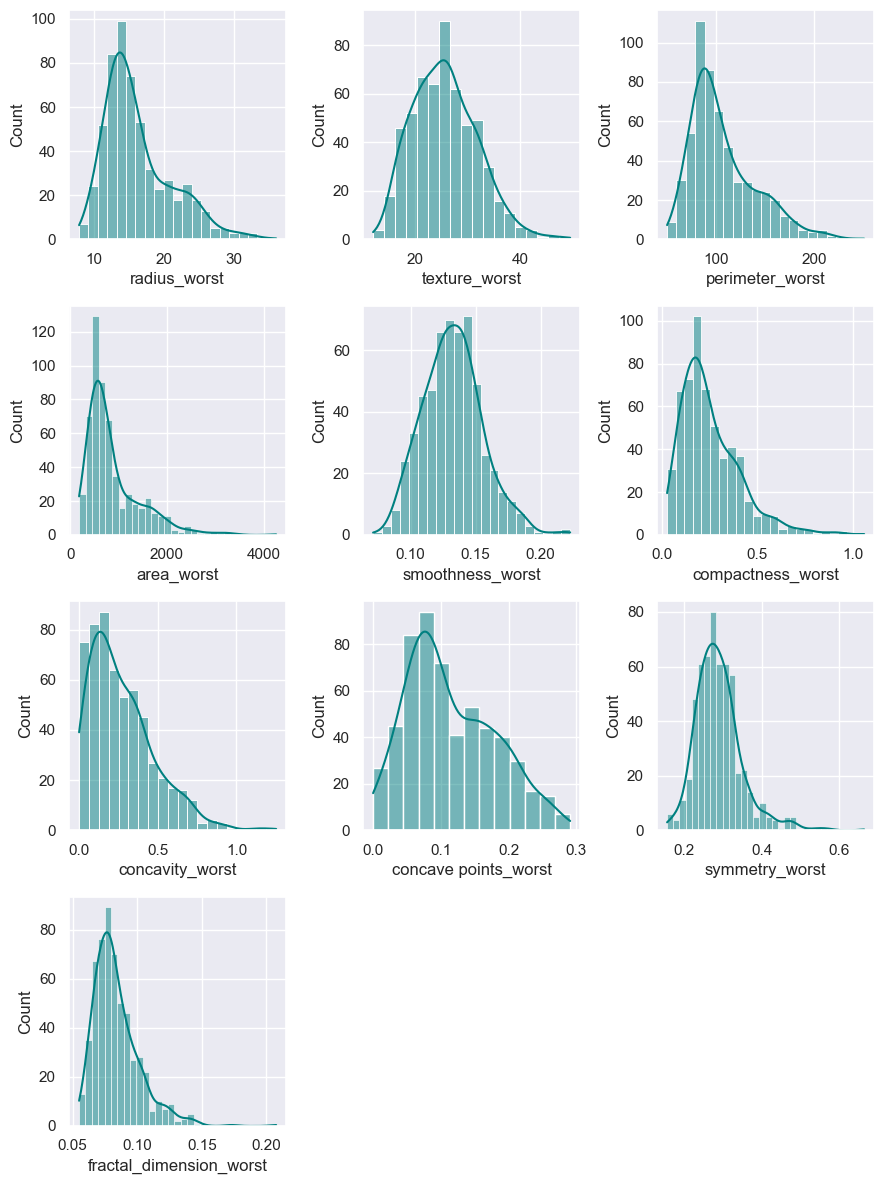

In [22]:
histograms_plot(worst_features, worst_features, 4,3)

Observo como en todas las features presenta desvacion a la derecha, especialmente en el grupo de "se". Esto se debe a sus outliers 

### Countplot target

<AxesSubplot:xlabel='diagnosis', ylabel='count'>

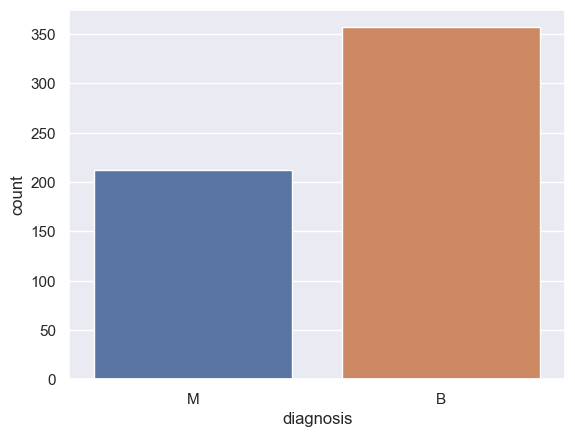

In [23]:
sns.countplot(x=data_y)

In [24]:
count_m = data_y.value_counts()[1]/data_y.shape[0]*100
count_b= data_y.value_counts()[0]/data_y.shape[0]*100

print(f"Diagnosticos malignos son {round(count_m,2)} y benignos son {round(count_b,2)}")



Diagnosticos malignos son 37.26 y benignos son 62.74


Se observa una mayor cantidad de targets benignos.

## 4.2 Multivariate Analysis  

### Boxplot

Voy a visualizar mediante boxplot para observar si hay diferencia entre los target y features, pero antes por sus diferencias de magnitudes tengo que normalizarlos

In [25]:
from scipy.stats import zscore
sns.set(style="whitegrid")

def boxplot_standar(features, target):
    features_scaler = zscore(features)      
    dataframe = pd.concat([target, features_scaler], axis=1)
    dataframe = pd.melt(dataframe,id_vars="diagnosis", var_name="features", value_name='value')
    fig = plt.figure( figsize=(10, 10))       
    sns.boxenplot(x="features", y="value", hue="diagnosis", data=dataframe)      
    plt.xticks(rotation=90)
    fig.tight_layout()  
    plt.show()    

Mean

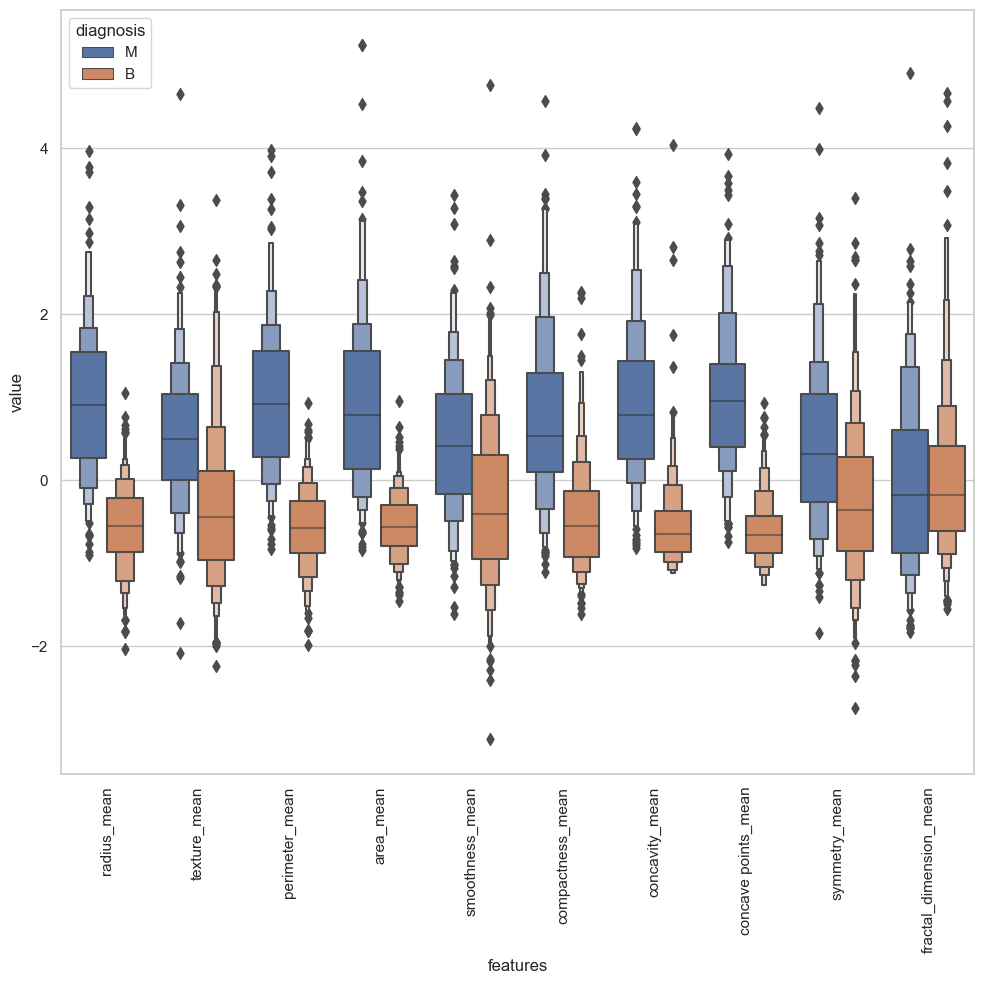

In [26]:
boxplot_standar(mean_features, data_y)

Se observan diferencias marcadas entre la mediana de todos los features (salvo fractal_dimension_mean) en relacion al target por lo cual puede servirnos para el modelo de clasificacion.



Standard Error

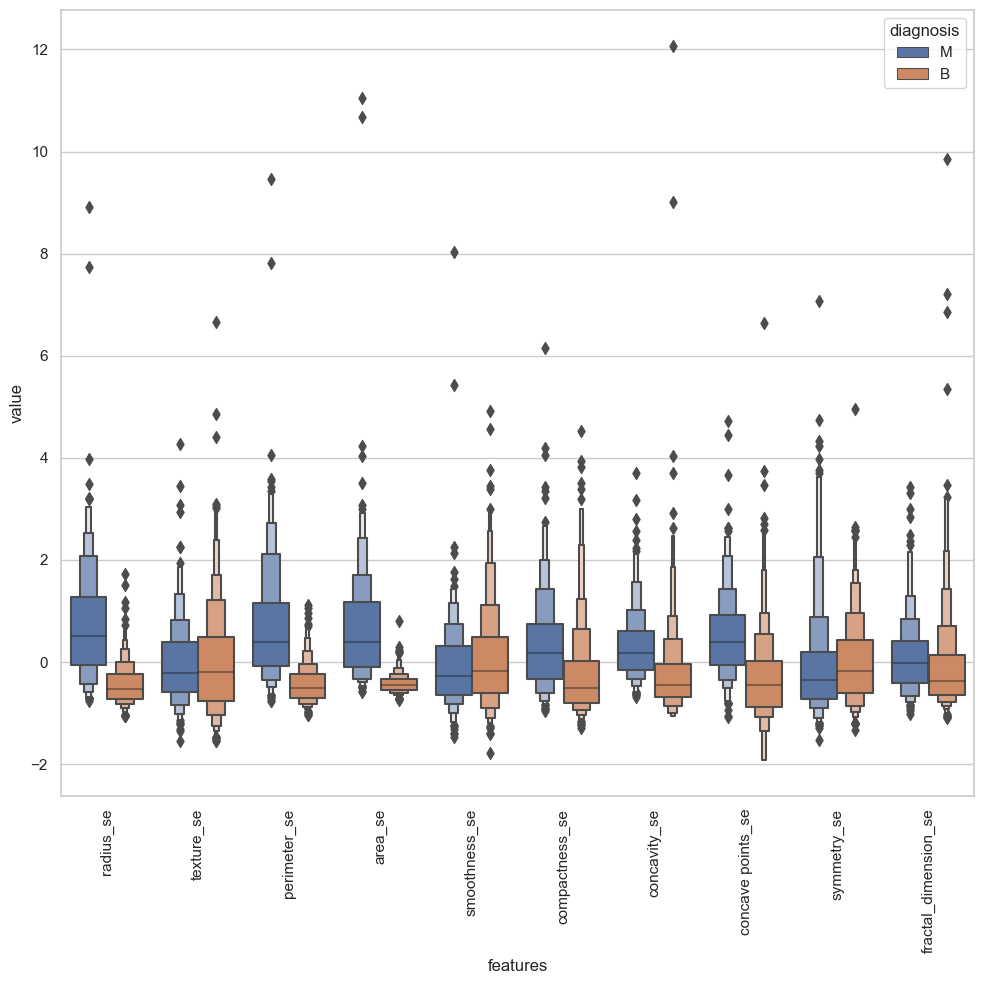

In [27]:
boxplot_standar(se_features, data_y)

Se observa una mayor cantidad de outliers concordante con la distribucion sesgada a la derecha previamente visualizada

Worst

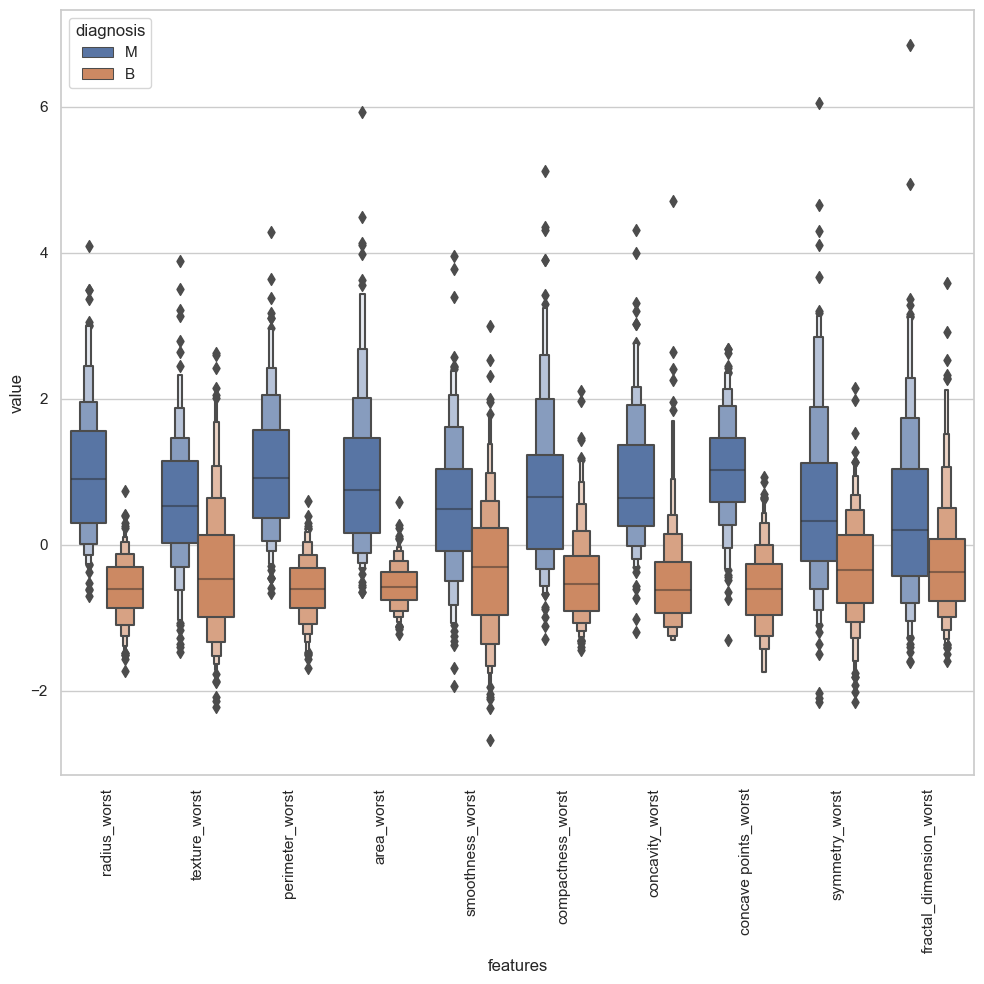

In [28]:
boxplot_standar(worst_features, data_y)

Mismo planteamiento que en la visualizacion de "mean"


### Correlacion

Ahora vamos a darle un vistazo en buqueda de correlacion entre las features

In [29]:
# Creo funcion para heatmap de corr

import seaborn as sns; sns.set_theme()

def corr_heatmap(data, target):
    data_dummie = pd.concat([target, data], axis=1)
    corr =data_dummie.corr()
    fig,ax = plt.subplots(figsize=(15,15))
    cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
    matrix = np.triu(corr)
    sns.heatmap(corr, annot=True, linewidths=.5, fmt= '.1f',ax=ax, cmap=cmap, mask=matrix)

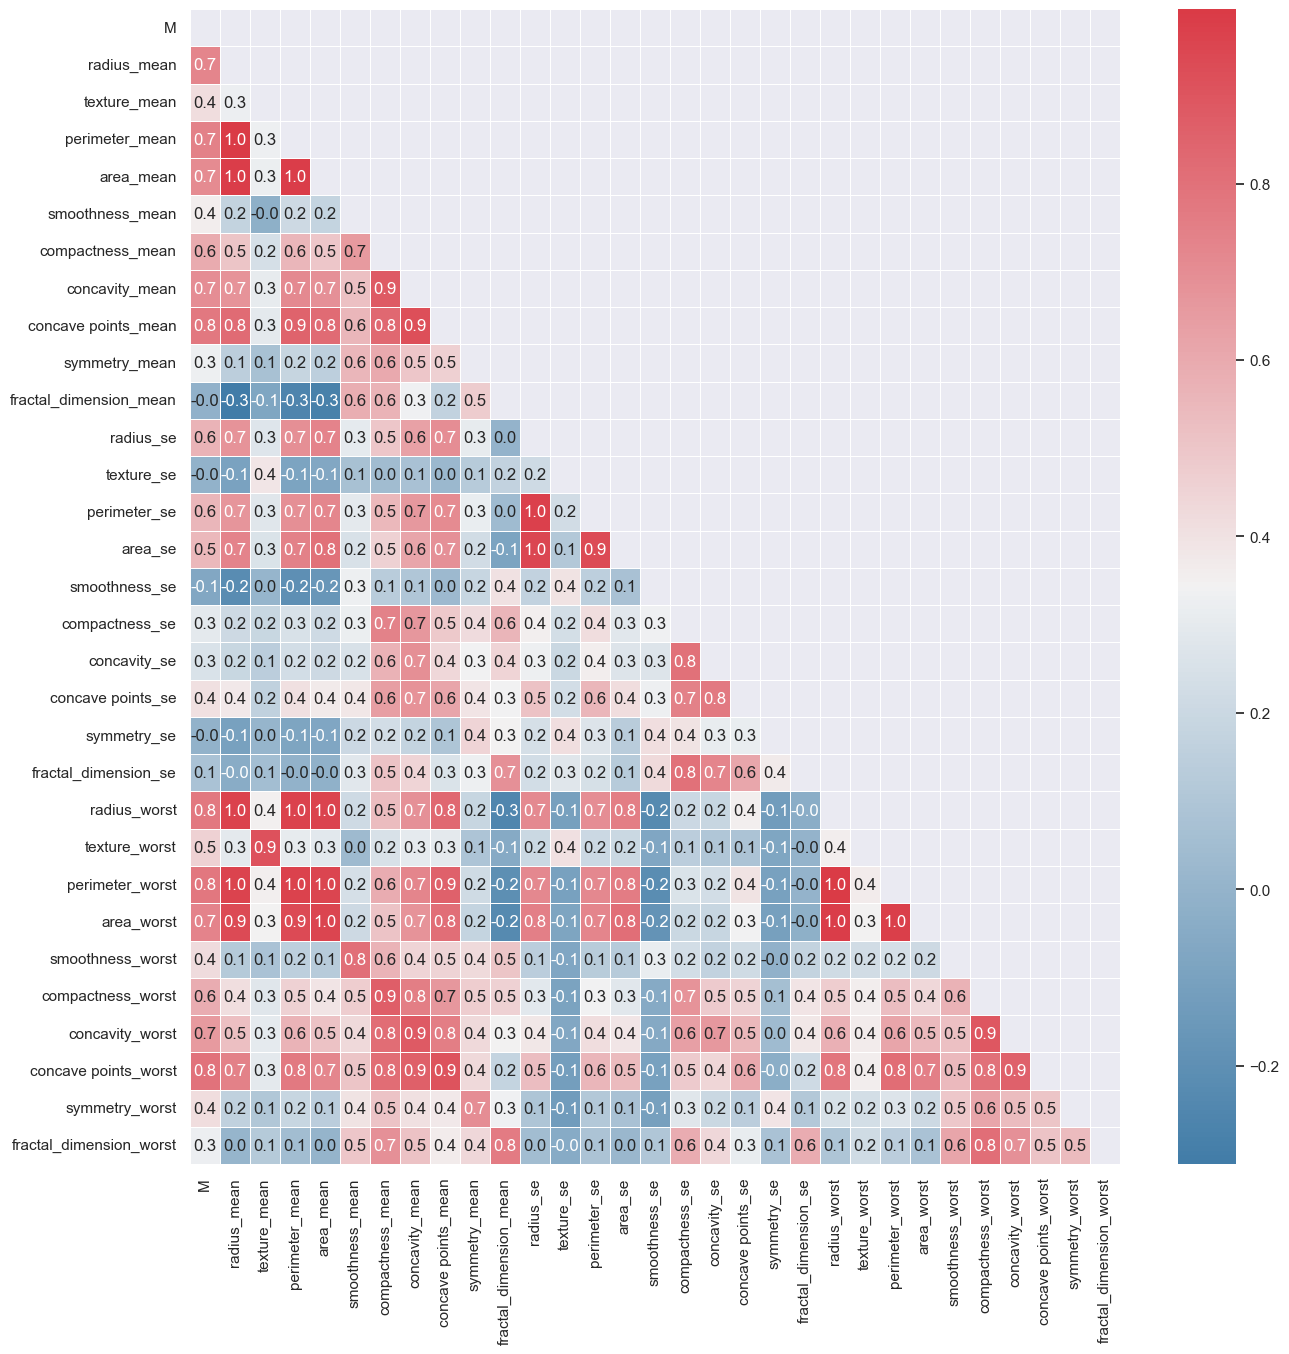

In [30]:
corr_heatmap(data_x, Y)


In [31]:
# Mediante esta funcion voy a tener ordenadas de mayor a menor las principales correlaciones ( positivas y negativas) 

def get_positive_corr_coefficient(data, target):
    data_dummie = pd.concat([target, data], axis=1)    
    positive_corr_df = data_dummie.corr(method='pearson')
    positive_corr_df = positive_corr_df.mask(np.tril(np.ones(positive_corr_df.shape)).astype(bool))
    positive_corr_df = positive_corr_df[abs(positive_corr_df) > 0.7].stack().reset_index().sort_values(by=0, ascending=False)
    positive_corr_df.rename(columns={0: "pearson_coefficient"}, inplace=True)
    return positive_corr_df

def get_negative_corr_coefficient(data, target):
    data_dummie = pd.concat([target, data], axis=1)    
    negative_corr_df = data_dummie.corr(method='pearson')
    negative_corr_df = negative_corr_df.mask(np.tril(np.ones(negative_corr_df.shape)).astype(bool))
    negative_corr_df = negative_corr_df[abs(negative_corr_df) < 0.3].stack().reset_index().sort_values(by=0)
    negative_corr_df.rename(columns={0: "pearson_coefficient"}, inplace=True)
    return negative_corr_df



Busco las principales features con correlaciones positivas

In [32]:
positive_corr = get_positive_corr_coefficient(data_x, Y)
positive_corr.head(10)

level_0          level_1  pearson_coefficient
8       radius_mean   perimeter_mean             0.997855
68     radius_worst  perimeter_worst             0.993708
9       radius_mean        area_mean             0.987357
17   perimeter_mean        area_mean             0.986507
69     radius_worst       area_worst             0.984015
71  perimeter_worst       area_worst             0.977578
52        radius_se     perimeter_se             0.972794
22   perimeter_mean  perimeter_worst             0.970387
12      radius_mean     radius_worst             0.969539
21   perimeter_mean     radius_worst             0.969476

Observamos que las variables que tienen mayor relacion entre ellas son radius_mean, perimeter_mean, radius_worst, perimeter_worst, area_mean.

Ahora voy a buscar las que tienen mayor correlacion con el Target

In [33]:
mask_corr_M = positive_corr["level_0"] == "M"

positive_corr.loc[positive_corr["level_0"] == "M"] #Tengo las principales featurs con correlacion para que sea maligno

level_0               level_1  pearson_coefficient
7       M  concave points_worst             0.793566
5       M       perimeter_worst             0.782914
3       M   concave points_mean             0.776614
4       M          radius_worst             0.776454
1       M        perimeter_mean             0.742636
6       M            area_worst             0.733825
0       M           radius_mean             0.730029
2       M             area_mean             0.708984

Observo que las principales correlaciones con el target "M" son:
- concave points_worst
- perimeter_worst
- concave points_mean
- radius_worst
- perimeter_mean
- area_worst
- radius_mean
- area_mean. 

Son las que voy a utilizar para mi modelo

Hago lo mismo con las negativas

In [34]:
negative_corr = get_negative_corr_coefficient(data_x, Y)
negative_corr.head(10)

level_0                 level_1  pearson_coefficient
52                area_mean  fractal_dimension_mean            -0.283110
40           perimeter_mean  fractal_dimension_mean            -0.261477
98   fractal_dimension_mean            radius_worst            -0.253691
101  fractal_dimension_mean              area_worst            -0.231854
145           smoothness_se            radius_worst            -0.230691
10              radius_mean           smoothness_se            -0.222600
147           smoothness_se         perimeter_worst            -0.217304
100  fractal_dimension_mean         perimeter_worst            -0.205151
42           perimeter_mean           smoothness_se            -0.202694
148           smoothness_se              area_worst            -0.182195

In [35]:
mask_corr_M = negative_corr["level_0"] == "M"

negative_corr.loc[negative_corr["level_0"] == "M"] 

level_0                 level_1  pearson_coefficient
2       M           smoothness_se            -0.067016
0       M  fractal_dimension_mean            -0.012838
1       M              texture_se            -0.008303
5       M             symmetry_se            -0.006522
6       M    fractal_dimension_se             0.077972
4       M            concavity_se             0.253730
3       M          compactness_se             0.292999

Observo que salvo smoothness_se, el resto no tiene una gran correlacion negativa con "M", lo que me deja claro que la relacion de las features con el target es principalmente con su Malignidad

### Scatterplot

In [36]:
# Creo una variable para poder observar como se comporta la distribucion de las features. Solo voy a usar las del grupo "mean", ya que es redundante realizar con los otros 2 grupos

scater_mean = pd.concat([data_y, mean_features], axis=1)

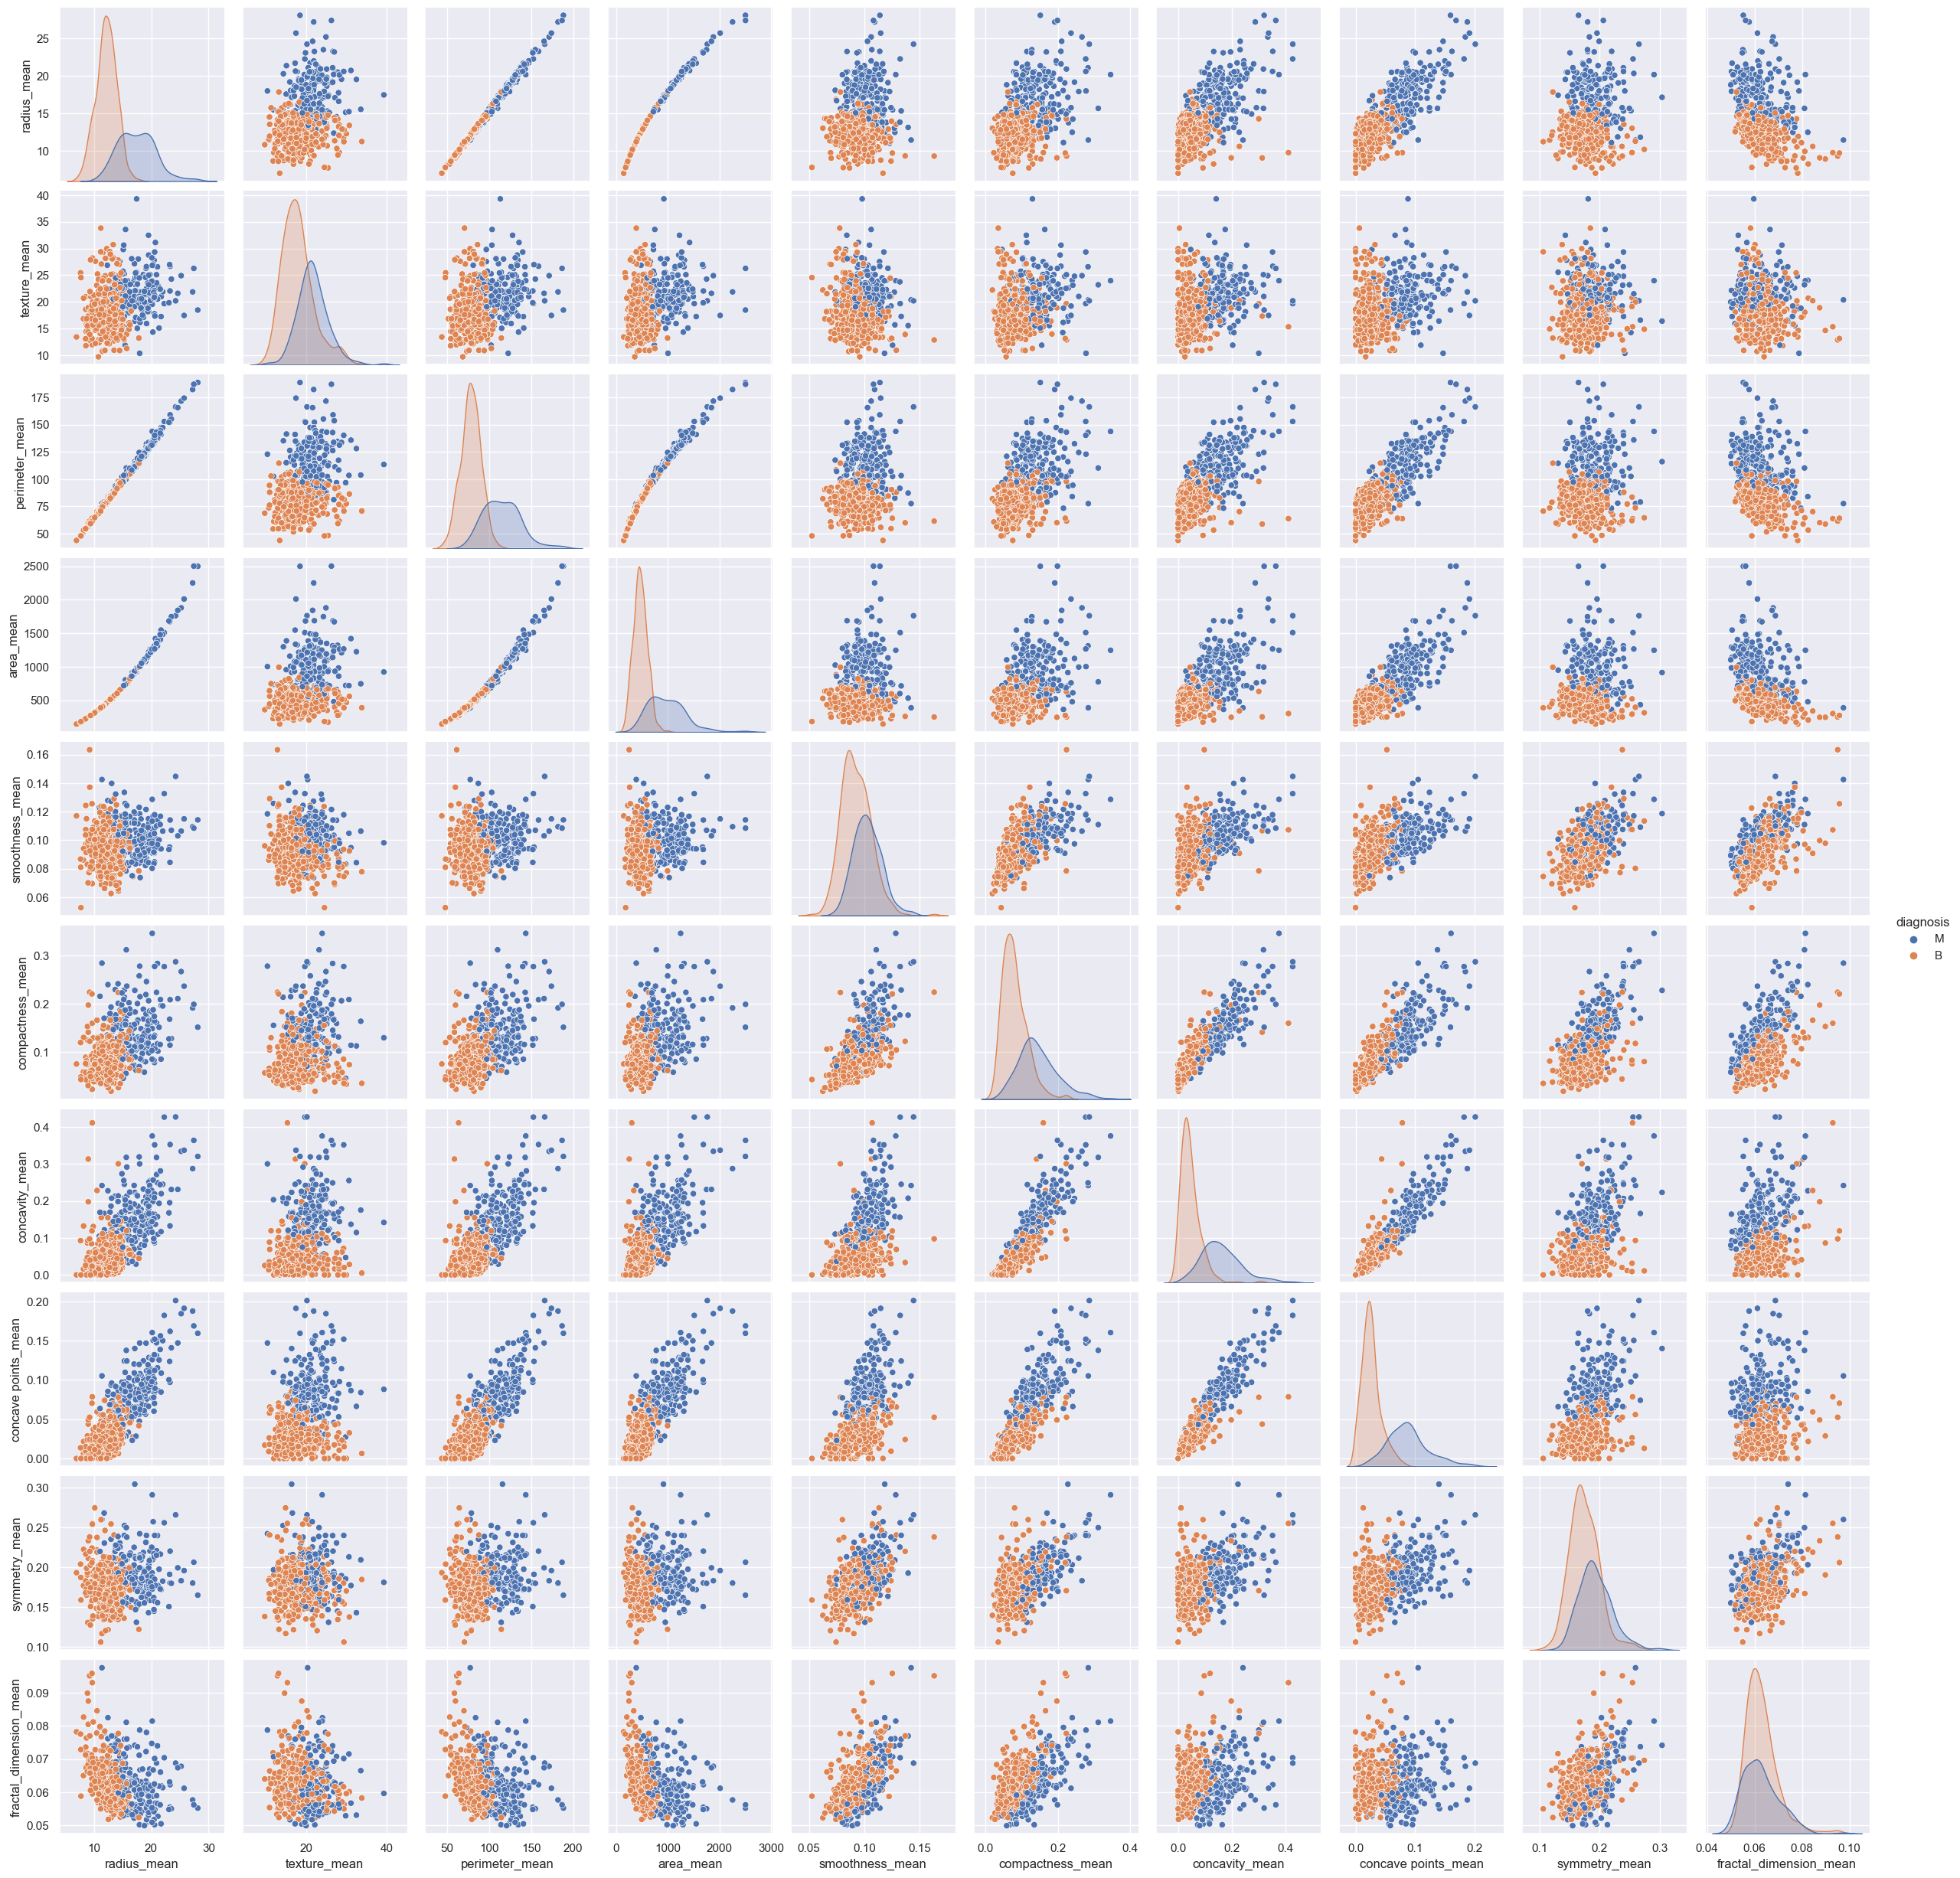

In [37]:
sns.pairplot(scater_mean, hue="diagnosis")

Se observa claramente la tendencia positiva que tiene el diagnostico "Maligno" con la mayoria de la features.

Ademas se eviencia la gran correlacion positiva entre perimetro, area y radio.

# 5 Machine Learning


## 5.1 Data Procesing

Comienzo a preprocesar los datos para poder utilizarlos en el modelo

### Convierto las etiquetas de string a numericas (int)

In [38]:
# Convierto las etiqueta de string a numericas (int)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y= le.fit_transform(data_y)
# B=0, M = 1


### Funciones para separar data

In [39]:
def normalize_model(target, features_select):
    """
    Separa el target y lo normaliza
    """
    y = target
    X = features_select
    scaler = preprocessing.StandardScaler().fit(X)
    X = pd.DataFrame (scaler.transform(X))
    return X, y


def split_and_normalize_model(target, selected_data, ratio, random_state):
    """
    Separa mis muestras de entrenamiento y test
    """
    X, y = normalize_model(target, selected_data)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio, random_state=random_state)

    print(f'Train Shape: {X_train.shape}')
    print(f'Test Shape: {X_test.shape}')
    return X_train, X_test, y_train, y_test

### Funcion RFEC

In [40]:
# Usar RFECV 
from sklearn.feature_selection import RFECV

def get_best_features_by_RFECV(model, X_train, y_train, data):
    # Uso RFECV para elegir las mejores features
    selector = RFECV(estimator=model, step=1, 
                     cv=5, scoring='accuracy')
    selector = selector.fit(X_train, y_train)
    features_names = selector.get_support(1)
    best_features = data.columns[features_names]    
    print(f'Optimal number of features: {selector.n_features_}')
    print()
    print(f'Best features: \n')
    print(f'{best_features}')
    
    
    selected_features = selector.get_support(1)
    X_selected_features = data[data.columns[selected_features]]
    return X_selected_features

### Funciones para evaluar modelos

In [41]:
# Area bajo la curva

def auc_plot(xtest, ytest, model):
    yproba = model.predict_proba(xtest)
    fpr1, tpr1, thresholds = roc_curve(ytest.astype('int'), yproba[:,1], drop_intermediate = False)
    auc = metrics.auc(fpr1, tpr1)
    print("El AUC es = " + str(auc))

    plt.plot(fpr1, tpr1, lw=2, alpha=0.7 , label = 'ROC curve', color = 'b')
    plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r',label='Luck', alpha=.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(False)
    plt.legend(loc="lower right")
    plt.title('ROC curve')
    plt.show()
    


In [42]:
# Matrix de confusion

def cm_plot(ytest, ypred):
    cm = confusion_matrix(ytest, ypred)
    df_cm = pd.DataFrame(cm, index = ['Cancer', 'Control'], columns = ['Cancer', 'Control'])
    plt.figure(figsize = (6,4))
    sns.heatmap(df_cm, annot=True)
    plt.title('Classification Confusion matrix')
    plt.show()


In [43]:
from sklearn.metrics import accuracy_score
#Creo funcion para realizar accuracy y ademas guardarlo en una lista para poder compararlo mas adelante

list_accuracy = {}

def accuracy_model(y_test, ypred, model=""):
    test_acc = accuracy_score(y_test_selec, ypred)
    list_accuracy[model] = round(test_acc,3)
    print("El accuracy es " + str(test_acc))

### 5.2.a Logic Regression con las features seleccionadas por EDA

In [44]:
# Seleccionamos nuestro dataset con las features elegidas

features_selec = ["concave points_worst", "perimeter_worst", "concave points_mean", "radius_worst", "perimeter_mean", "area_worst", "radius_mean", "area_mean"]

x_prueba = data_x.loc[:,features_selec]
x_prueba

concave points_worst  perimeter_worst  concave points_mean  \
id                                                                     
842302                  0.2654           184.60              0.14710   
842517                  0.1860           158.80              0.07017   
84300903                0.2430           152.50              0.12790   
84348301                0.2575            98.87              0.10520   
84358402                0.1625           152.20              0.10430   
...                        ...              ...                  ...   
926424                  0.2216           166.10              0.13890   
926682                  0.1628           155.00              0.09791   
926954                  0.1418           126.70              0.05302   
927241                  0.2650           184.60              0.15200   
92751                   0.0000            59.16              0.00000   

          radius_worst  perimeter_mean  area_worst  radius_mean  area_mean  
id                                                                          
842302          25.380          122.80      2019.0        17.99     1001.0  
842517          24.990          132.90      1956.0        20.57     1326.0  
84300903        23.570          130.00      1709.0        19.69     1203.0  
84348301        14.910           77.58       567.7        11.42      386.1  
84358402        22.540          135.10      1575.0        20.29     1297.0  
...                ...             ...         ...          ...        ...  
926424          25.450          142.00      2027.0        21.56     1479.0  
926682          23.690          131.20      1731.0        20.13     1261.0  
926954          18.980          108.30      1124.0        16.60      858.1  
927241          25.740          140.10      1821.0        20.60     1265.0  
92751            9.456           47.92       268.6         7.76      181.0  

[569 rows x 8 columns]

In [45]:
# Split and normalize
#Ratio de 20% test y 80% train
X_train_selec, X_test_selec, y_train_selec, y_test_selec = split_and_normalize_model(y, x_prueba, 0.2, random_state=43)

Train Shape: (455, 8)
Test Shape: (114, 8)


In [46]:
# Creo variable para Logistic Regression

lr = LogisticRegression()

#Fit data train
_ = lr.fit(X_train_selec, y_train_selec)

# Realizo prediccion
ypred = _.predict(X_test_selec)
ypred

array([0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0])

In [47]:
accuracy_model(y_test_selec, ypred, "Logistic_Regression")


El accuracy es 0.9649122807017544


El AUC es = 0.9883760683760684


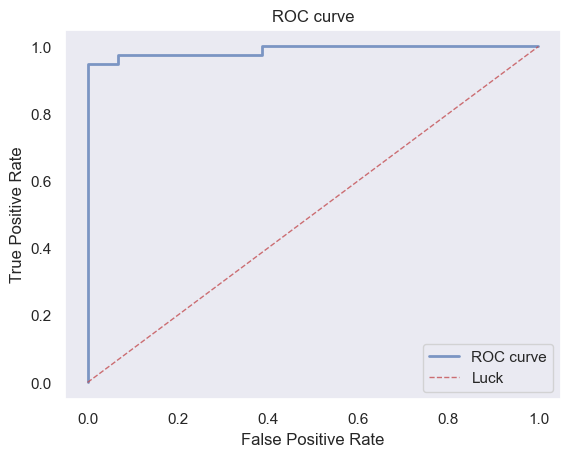

In [48]:
auc_plot(X_test_selec, y_test_selec, lr)

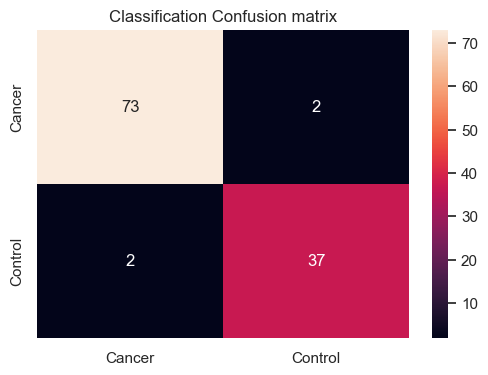

In [49]:
cm_plot(y_test_selec, ypred)

Con las features seleccionadas por EDA llegamos a un 96% de accuracy y un 98% con AUC. Ahora probaremos con Random Forest Classifier


## 5.2.b Random Forest Classifier

In [50]:
# Seleccionamos modelo
rf = RandomForestClassifier()

#Lo fiteamos
_rf = rf.fit(X_train_selec, y_train_selec)

#Predecimos
ypredrf = _rf.predict(X_test_selec)
ypredrf

array([0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0])

In [51]:
accuracy_model(y_test_selec, ypredrf, "RandomForest Classifier")

El accuracy es 0.9912280701754386


El AUC es = 0.9822222222222221


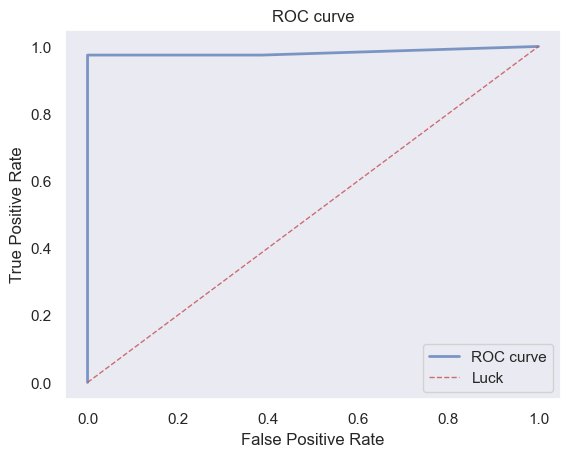

In [52]:
auc_plot(X_test_selec, y_test_selec, rf)

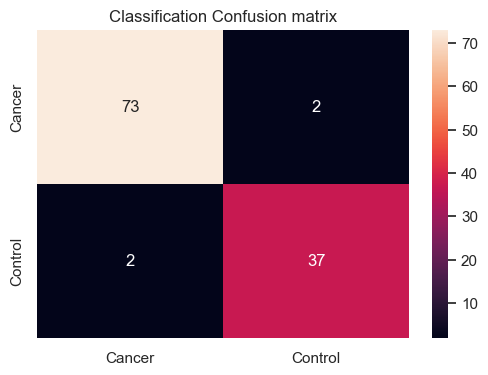

In [53]:
cm_plot(y_test_selec, ypred)

Observamos un accuracy de aproximadamente 96% y un area de bajo la curva 98%. Muy parecido los resultados con ambos modelos.

## 5.3 GridSearchCV for Models with Recursive Feature Elimination with Cross-validation (RFECV)

[RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html)

[GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) 


Vamos a realizar RFECV para encontrar cuales features son las mejores para mi modelo, y realizar Grid Search para encontrar los mejores hyperparametros de los mismos



## 5.3.a Logistic Regression (GridSearchCV - RFECV)

In [54]:
# Primero split y normalizo mis datos con todas las features 

X_train_lr_rfecv, X_test_lr_rfecv, y_train_lr_rfecv, y_test_lr_rfecv = split_and_normalize_model(y, data_x, 0.2, random_state=43)


Train Shape: (455, 30)
Test Shape: (114, 30)


### RFECV

In [55]:
# Realizo rfecv para encontrar las mejores features para LR

X_select_rfecv_lr =  get_best_features_by_RFECV(lr, X_train_lr_rfecv, y_train_lr_rfecv, data_x)


Optimal number of features: 24

Best features: 

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'concavity_mean', 'concave points_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'compactness_se',
       'concavity_se', 'concave points_se', 'fractal_dimension_se',
       'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst',
       'smoothness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')


Eligio 24 features, ahora vamos a realiar gridsearch para encontrar los mejores parametros para este modelo

Vuelvo a separar y fit mi dataset con los features seleccionados

In [56]:
# Vuelvo a split y normalizar solo las features seleccionadas
X_train_lr_rfecv, X_test_lr_rfecv, y_train_lr_rfecv, y_test_lr_rfecv = split_and_normalize_model(y, X_select_rfecv_lr, 0.2, random_state=43)

Train Shape: (455, 24)
Test Shape: (114, 24)


### GridSearch

In [57]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Hyperparametros
parameters = {'penalty':['l1', 'l2'], 
                 'C': [100, 10, 1.0, 0.1, 0.01],
                 'solver': ['liblinear']}
# 
clf_lr = GridSearchCV(lr, # modelo
                   param_grid = parameters, # Hyperparametros
                   refit = True, # refit nos devuelve el modelo con los mejores parametros encontrados 
                   cv = 5,
                   verbose=1) # cv indica la cantidad de folds
                   

# Fit el modelo ya seleccionado
clf_lr.fit(X_train_lr_rfecv, y_train_lr_rfecv.ravel())


Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             verbose=1)

In [58]:
# Observo cuales fueron los mejores hyperparametros

print("Los mejores parametros fueron %s con un score de %0.2f" % (clf_lr.best_params_, clf_lr.best_score_))

Los mejores parametros fueron {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'} con un score de 0.98


Fit mi modelo con las variables y parametros seleccionados

In [59]:
#Realizo prediccion con mi modelo ya entrenado

ypred_rfecv_lr = clf_lr.predict(X_test_lr_rfecv)
ypred_rfecv_lr

array([0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0])

In [60]:
accuracy_model(y_test_lr_rfecv, ypred_rfecv_lr, "Loggistic_Regression_RFCV_GS")

El accuracy es 0.9736842105263158


El AUC es = 0.987008547008547


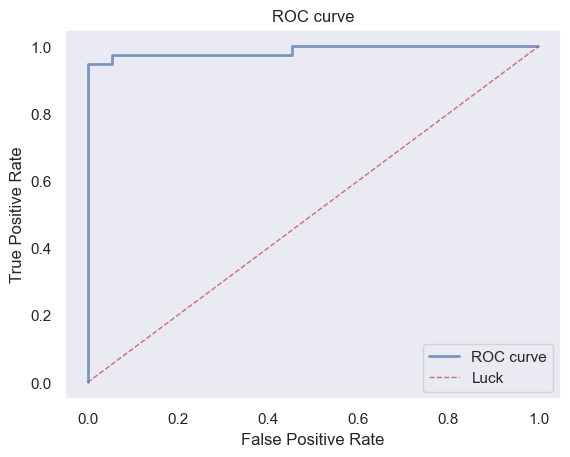

In [61]:
auc_plot( X_test_lr_rfecv, y_test_lr_rfecv, clf_lr)


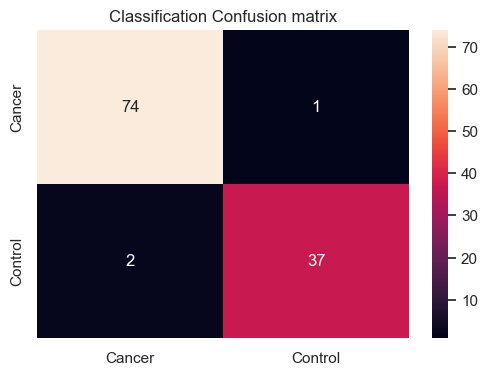

In [ ]:
cm_plot(y_test_lr_rfecv, ypred_rfecv_lr)

Se observa un acurracy de 97% con las features selccionadas y un AOC del 98%. Mejoro 1% la accuracy


## 5.3.b Random Forest Classifier (GridSearchCV - RFECV)

In [72]:
# Primero split y normalizo mis datos con todas las features de nuevo

X_train_rf_rfecv, X_test_rf_rfecv, y_train_rf_rfecv, y_test_rf_rfecv = split_and_normalize_model(y, data_x, 0.2, random_state=43)

Train Shape: (455, 30)
Test Shape: (114, 30)


In [73]:
# Realizo rfecv para encontrar las mejores features para Random Forest Classifier 

X_select_rfecv_rf =  get_best_features_by_RFECV(rf, X_train_rf_rfecv, y_train_rf_rfecv, data_x)


Optimal number of features: 15

Best features: 

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'concavity_mean', 'concave points_mean', 'area_se', 'radius_worst',
       'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst',
       'concavity_worst', 'concave points_worst', 'symmetry_worst'],
      dtype='object')


Elige 15 features de 30, la mitad.

In [74]:
# Vuelvo a split y normalizar solo las features seleccionadas
X_train_rf_rfecv, X_test_rf_rfecv, y_train_rf_rfecv, y_test_rf_rfecv = split_and_normalize_model(y, X_select_rfecv_rf, 0.2, random_state=43)

Train Shape: (455, 15)
Test Shape: (114, 15)


In [76]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Hyperparametros
parameters = {'bootstrap': [True], 
            'max_depth': [5, 10, None], 
            'max_features': ['auto', 'log2'], 
            'n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 15]}

clf_rf = GridSearchCV(rf, 
                   param_grid = parameters, 
                   refit = True, 
                   cv = 5,
                   verbose=0) 
                   

# Fit el modelo ya seleccionado
clf_rf.fit(X_train_rf_rfecv, y_train_rf_rfecv.ravel())


Fitting 5 folds for each of 60 candidates, totalling 300 fits


c:\Users\jpans\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\jpans\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\jpans\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [5, 10, None],
                         'max_features': ['auto', 'log2'],
                         'n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 15]},
             verbose=1)

In [77]:
# Observo cuales fueron los mejores hyperparametros

print("Los mejores parametros fueron %s con un score de %0.2f" % (clf_rf.best_params_, clf_rf.best_score_))

Los mejores parametros fueron {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 13} con un score de 0.96


In [78]:
#Realizo prediccion con mi modelo ya entrenado

ypred_rfecv_rf = clf_rf.predict(X_test_rf_rfecv)
ypred_rfecv_rf

array([0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0])

In [79]:
accuracy_model(y_test_rf_rfecv, ypred_rfecv_rf, "Random_Forest_Classifier_RFCV_GS")

El accuracy es 0.9736842105263158


El AUC es = 0.9741880341880342


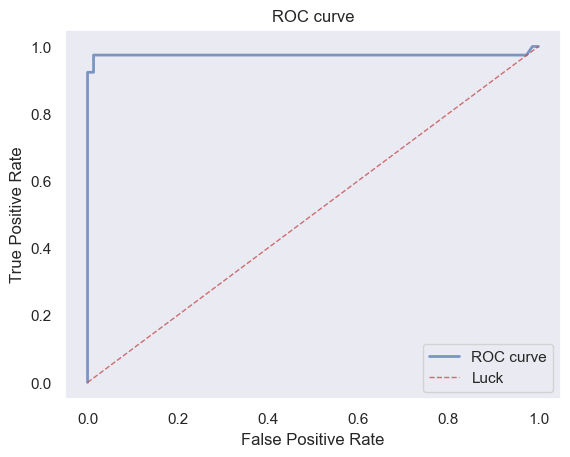

In [82]:
auc_plot(X_test_rf_rfecv, y_test_rf_rfecv, clf_rf)

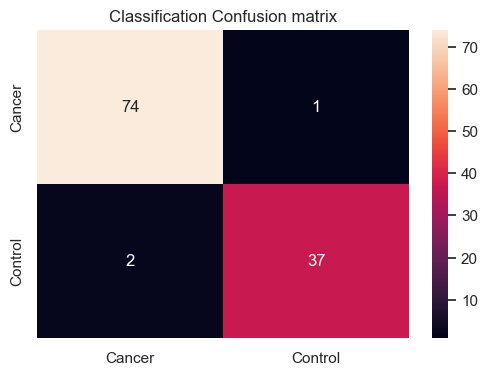

In [83]:
cm_plot(y_test_rf_rfecv, ypred_rfecv_rf)


# 6. Score de Accuracy

In [84]:
modelos= list(list_accuracy.keys())
score= list(list_accuracy.values())

list_accurary_score = pd.DataFrame({"Modelos": modelos, "Accuracy": score})

list_accurary_score.sort_values(by="Scores", ascending=False)

Modelos  Scores
1           RandomForest Classifier   0.991
2      Loggistic_Regression_RFCV_GS   0.974
3  Random_Forest_Classifier_RFCV_GS   0.974
0               Logistic_Regression   0.965

# 7. Conclusión

Observamos que el modelo que tuvo el mayor accuracy fue RandomForest Classifier utilizando una seleccion manual sobre el analisis de sus datos con 99%. El resto de los modelos se mantuvieron a un buen nivel de acurracy, solo por debajo entre 1-2% del primero. 

El analisis exploratorio de las variables es fundamental para poder encontrar cuales features son las que nos van a servir en nuestro modelo. Hay que prestar atencion a esto ya que ingresar variables innecesarias se logra complejizar mas de lo que deberia a nuestro modelo.

Por otro lado tener una herramienta como RFECV es importante para las analisis de multiples features donde es engorroso encontrar las principales variables que nos van a ofrecer un mejor rendimiento de nuestro modelo. Como vimos, en poco tiempo pudimos encontrar las features necesarias para llegar a un buen nivel de accuracy .



